<a href="https://colab.research.google.com/github/iarolls/Hackathon/blob/main/Mask_CycleGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pylab as plt
import matplotlib.image as img
import os
import time
import numpy as np
from PIL import Image
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

In [ ]:
# moving files into directory
# for item in os.listdir():
#   if(not os.path.isfile(item)):
#     continue
#   os.rename(item, 'no_mask/' + item)

# renaming items to .jpg
# path = 'mask/'
# for item in os.listdir(path):
#   # print(item[:-1])
#   os.rename(path + item, path + item[:-1] + 'eg')

# fixing jpeegs:
# path = 'mask/'
# for item in os.listdir(path):
#   os.rename(path + item, path + item[:-2] + 'g')

In [ ]:
data_dir = 'no_mask'
image_size = (256, 256)
img_height = img_width = 256
batch_size = 1

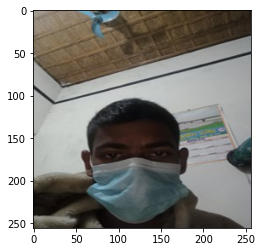

In [ ]:
im = img.imread('mask/002877_1_002877_NONE_20.jpeg')
imgplot = plt.imshow(im)

In [ ]:
for item1 in os.listdir('mask'):
  for item2 in os.listdir('no_mask'):
    if item1[:6] == item2[:6]:
      print("item1: ", item1, "item2: ", item2)
      break
  break

item1:  002877_1_002877_NONE_20.jpeg item2:  002877_4_002877_NONE_20.jpeg


In [ ]:
# converting from filepaths to images
def parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image = tf.image.decode_jpeg(image_string, channels=3)
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

In [ ]:
# CREATING NO MASK DATASET
filenames = []
path = 'no_mask/'
for item in os.listdir(path)[0:10]:
  img = Image.open(path + item)
  filenames.append(path + item)
labels = np.zeros(len(filenames))

filenames = tf.convert_to_tensor(filenames, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

In [ ]:
no_mask_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
no_mask_dataset = no_mask_dataset.shuffle(len(filenames))
no_mask_dataset = no_mask_dataset.map(parse_function, num_parallel_calls=4)

In [ ]:
#CREATING MASK DATASET
filenames = []
path = 'mask/'
for item in os.listdir(path)[0:10]:
  img = Image.open(path + item)
  filenames.append(path + item)
labels = np.zeros(len(filenames))

filenames = tf.convert_to_tensor(filenames, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

In [ ]:
mask_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
mask_dataset = mask_dataset.shuffle(len(filenames))
mask_dataset = mask_dataset.map(parse_function, num_parallel_calls=4)

In [ ]:
one_mask_dataset = tf.data.Dataset.from_tensor_slices((['mask/002877_1_002877_NONE_20.jpeg'], [0]))
one_mask_dataset = one_mask_dataset.shuffle(len(filenames))
one_mask_dataset = one_mask_dataset.map(parse_function, num_parallel_calls=4)

In [ ]:
# CREATING TEST DATASETS

In [ ]:
# CREATING NO MASK DATASET
filenames = []
path = 'no_mask/'
for item in os.listdir(path)[50:60]:
  img = Image.open(path + item)
  filenames.append(path + item)
labels = np.zeros(len(filenames))

filenames = tf.convert_to_tensor(filenames, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

In [ ]:
no_mask_test_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
no_mask_test_dataset = no_mask_test_dataset.shuffle(len(filenames))
no_mask_test_dataset = no_mask_test_dataset.map(parse_function, num_parallel_calls=4)

In [ ]:
one_no_mask_dataset = tf.data.Dataset.from_tensor_slices((['no_mask/002877_4_002877_NONE_20.jpeg'], [0]))
one_no_mask_dataset = one_no_mask_dataset.shuffle(len(filenames))
one_no_mask_dataset = one_no_mask_dataset.map(parse_function, num_parallel_calls=4)

In [ ]:
#CREATING MASK DATASET
filenames = []
path = 'mask/'
for item in os.listdir(path)[50:60]:
  img = Image.open(path + item)
  filenames.append(path + item)
labels = np.zeros(len(filenames))

filenames = tf.convert_to_tensor(filenames, dtype=tf.string)
labels = tf.convert_to_tensor(labels, dtype=tf.float32)

In [ ]:
mask_test_dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
mask_test_dataset = mask_test_dataset.shuffle(len(filenames))
mask_test_dataset = mask_test_dataset.map(parse_function, num_parallel_calls=4)

In [ ]:
#DEMONSTRATING DATASETS WORK

In [ ]:
# print(type(mask_dataset.batch(10)))
# mask_dataset = mask_dataset.batch(1)
# no_mask_dataset = no_mask_dataset.batch(1)

In [ ]:
print(mask_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


In [ ]:
sample_no_mask = next(iter(no_mask_dataset))
sample_mask = next(iter(mask_dataset))
# print(sample_no_mask)
# sample_no_mask = next(iter(no_mask_train))

In [ ]:
# print(sample_no_mask.shape)
# print(tf.reshape(sample_no_mask[0], (1, 256, 256, 3)))
sample_no_mask = tf.reshape(sample_no_mask[0], (1, 256, 256, 3))
sample_mask = tf.reshape(sample_mask[0], (1, 256, 256, 3))

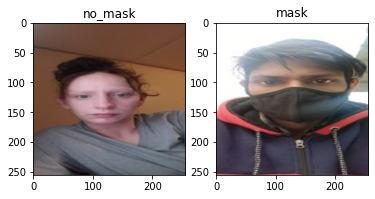

In [ ]:
plt.subplot(121)
plt.title('no_mask')
plt.imshow(sample_no_mask[0])
plt.subplot(122)
plt.title('mask')
plt.imshow(sample_mask[0])

In [ ]:
#BUILDING CYCLEGAN

In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
# creating generators and discriminators using existing pix2pix model
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

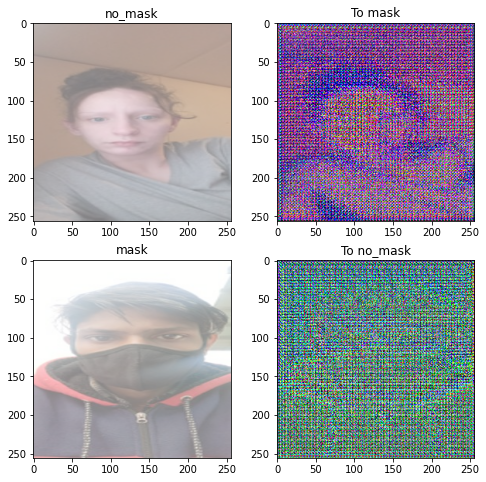

In [ ]:
# Generated results before training
# g: no_mask -> mask
# f: mask -> no_mask
to_mask = generator_g(sample_no_mask)
to_no_mask = generator_f(sample_mask)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_no_mask, to_mask, sample_mask, to_no_mask]
title = ['no_mask', 'To mask', 'mask', 'To no_mask']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

In [ ]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


In [ ]:
EPOCHS = 300

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [ ]:
# Needs to be uptaed, to change generator_f/g to be gen_no_mask and mask
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

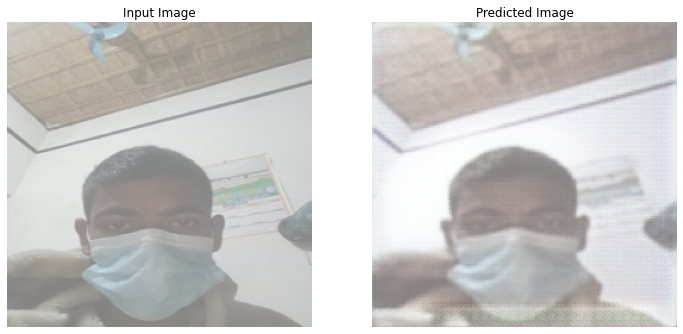

Time taken for epoch 28 is 10.834105730056763 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((one_mask_dataset, one_no_mask_dataset)):
    image_x = tf.reshape(image_x[0], (1, 256, 256, 3))
    image_y = tf.reshape(image_y[0], (1, 256, 256, 3))
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, image_x)

  if (epoch) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
for inp in one_mask_dataset.take(5):
  generate_images(generator_g, tf.reshape(inp[0], (1, 256, 256, 3)))